<a href="https://colab.research.google.com/github/mikhpo/ds-for-non-ds/blob/5-%D1%80%D0%B0%D0%B7%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0%D1%82%D1%8C-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C-%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE-%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F/notebooks/credit_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Решение задачи кредитного скоринга

Группа 1:
*   Поляков Михаил Юрьевич
*   Томилин Виктор Александрович
*   Макаров Никита Игоревич

[Репозиторий проекта](https://github.com/mikhpo/ds-for-non-ds) в GitHub.





## Импорт библиотек и настройка среды

Данные хранятся в базе данных PostgreSQL в Yandex Cloud. Для подключения к PostgreSQL-кластеру в Yandex Cloud необходимо загрузить SSL-сертификат.

In [1]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-05-28 20:04:07--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-05-28 20:04:08 (440 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



Все библиотеки импортированы в данном блоке в следующем порядке:
1. Модули стандартной библиотеки
2. Сторонние модули из каталога PyPI

In [2]:
import warnings

import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score, 
    confusion_matrix,
    precision_score, 
    recall_score, 
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from IPython.display import display

In [3]:
warnings.filterwarnings("ignore") # игнорировать предупреждения фильтрации
plt.style.use("default") # установка стиля графиков matplotlib

## Получение и сохранение данных

Получение данных из таблицы `credit_scoring` в базе данных `db_clients` из PostgreSQL-кластера в Yandex Cloud.

In [4]:
# Создание подключения к базе данных.
conn = psycopg2.connect("""
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""")

In [5]:
# Чтение данных из таблицы SQL-запросом и создание датафрейма Pandas.
query = "SELECT * from public.credit_scoring"

data = pd.read_sql_query(query, conn)

conn.close()

Сохранение данных в формате CSV.

In [6]:
data.to_csv("credit_scoring.csv", index=False)

## Разведочный анализ и подготовка данных

Описание данных:
* SeriousDlqin2yrs: Клиент имел просрочку 90 и более дней - целевая переменная.
* RevolvingUtilizationOfUnsecuredLines: Общий баланс средств (total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits).
* age: Возраст заемщика
* NumberOfTime30-59DaysPastDueNotWorse: Сколько раз за последние 2 года наблюдалась просрочка 30-59 дней.
* DebtRatio: Ежемесячные расходы (платеж по долгам, алиментам, расходы на проживания) деленные на месячный доход.
* MonthlyIncome: Ежемесячный доход.
* NumberOfOpenCreditLinesAndLoans: Количество открытых кредитов (напрмер, автокредит или ипотека) и кредитных карт.
* NumberOfTimes90DaysLate: Сколько раз наблюдалась просрочка (90 и более дней).
* NumberRealEstateLoansOrLines: Количество кредитов (в том числе под залог жилья)
* RealEstateLoansOrLines: Закодированное количество кредитов (в том числе под залог жилья) - чем больше код буквы, тем больше кредитов
* NumberOfTime60-89DaysPastDueNotWorse: Сколько раз за последние 2 года заемщик задержал платеж на 60-89 дней.
* NumberOfDependents: Количество иждивенцев на попечении (супруги, дети и др).
* GroupAge: закодированная возрастная группа - чем больше код, тем больше возраст.

In [7]:
display(data)
row_count = len(data)
col_count = len(data.columns)
print(f"Набор данных содержит {row_count} строк и {col_count} столбцов")

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
0,0,0.221813,43.0,0,0.527888,3280.0,7,0,0,2.0,A,c
1,0,0.602794,25.0,0,0.065868,333.0,2,0,0,0.0,A,b
2,1,0.025656,38.0,0,0.475841,3000.0,7,0,0,2.0,A,c
3,0,0.075427,32.0,0,0.085512,7916.0,6,0,0,0.0,A,b
4,0,0.046560,58.0,0,0.241622,2416.0,9,0,0,0.0,A,d
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.977899,63.0,0,517.000000,NaN,5,0,1,0.0,A,d
149996,0,0.025449,58.0,0,0.253855,15500.0,7,0,0,2.0,A,d
149997,0,0.058001,83.0,0,0.013997,5000.0,6,0,0,0.0,A,e
149998,0,0.071273,42.0,0,0.008638,6945.0,3,0,0,1.0,A,c


Набор данных содержит 150000 строк и 12 столбцов


### Описательная статистика набора данных

Технические параметры набора данных.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   135155 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 9   NumberOfDependents                    146076 non-null  float64
 10  RealEstateLoansOrLines                150000 non-null  object 
 11  

Общая описательная статистика.

In [9]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,135155.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.293618,0.421033,353.005076,6.670221e+03,8.452760,0.265973,0.240387,0.757222
std,0.249746,249.755371,14.772577,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,98.000000,20.000000


Статистика категориальных признаков.

In [10]:
data.describe(include="object")

,RealEstateLoansOrLines,GroupAge
count,150000,150000
unique,5,5
top,A,d
freq,140048,47268


Изучим сбалансированность набора данных по признаку **age**.

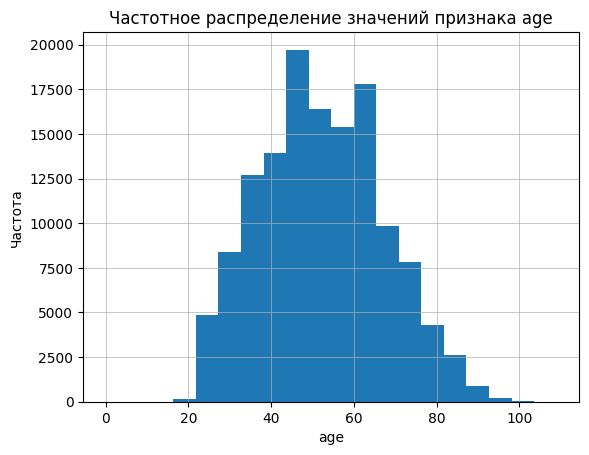

In [11]:
plt.hist(data["age"], bins=20)
plt.xlabel("age")
plt.ylabel("Частота")
plt.xticks(rotation="horizontal")
plt.title("Частотное распределение значений признака age")
plt.grid(linewidth=0.5)
plt.show()

Частотное распределение представляет собой колоколообразную кривую с пиком в центре диапазона значений, из чего можно сделать вывод, что набор данных достаточно хорошо сбалансирован по возрастному признаку.

### Распределение целевой переменной

Целевая переменная - поле **SeriousDlqin2yrs** - имел ли клиент просрочку 90 или более дней. Представляет собой категориальный признак, принимающий значения 1 и 0.

In [12]:
pivot_data = pd.pivot_table(data, index="SeriousDlqin2yrs", aggfunc={"SeriousDlqin2yrs": "count"})
pivot_data.rename(columns={"SeriousDlqin2yrs": "count"}, inplace=True)
pivot_data["share"] = pivot_data["count"]/len(data)
display(pivot_data)

,count,share
SeriousDlqin2yrs,,
0,139974,0.93316
1,10026,0.06684


Наблюдается существенный дисбаланс в распределении целевых значений. Визуализируем этот дисбаланс.

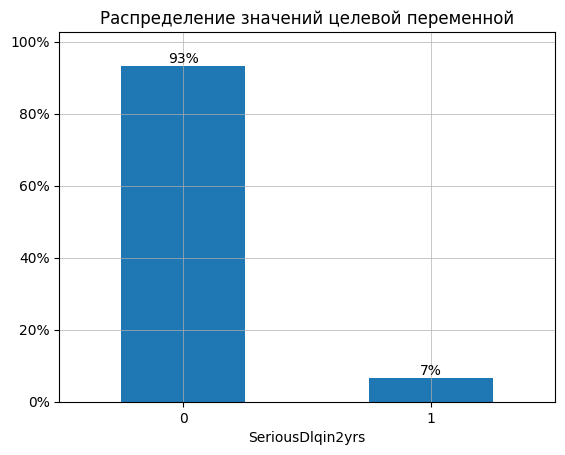

In [13]:
fig, ax = plt.subplots()
ax = pivot_data["share"].plot(kind="bar")
ax.grid(linewidth=0.5)
ax.bar_label(ax.containers[0], fmt="{:.0%}")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.title("Распределение значений целевой переменной")
plt.xticks(rotation="horizontal")
plt.margins(0.1, 0.1)
plt.show()

Дисбаланс классов целевых значений необходимо будет учесть при разработке модели машинного обучения.

### Обработка пропусков

Определим столбцы с пропусками.

In [14]:
data.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                     14845
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
RealEstateLoansOrLines                      0
GroupAge                                    0
dtype: int64

Пропуски обнаружены в полях **age**, **MonthlyIncome**, **NumberOfDependents**. Значения в этих полях числовые - следовательно, их можно заменить средними и медианными значениями. Воспользуемся медианными значениями, чтобы избежать влияния статистических выбросов.

In [15]:
for field in ("age", "MonthlyIncome", "NumberOfDependents"):
  median = data[field].median()
  print(f"Медианное значение поля {field} составляет {median}")
  data[field] = data[field].fillna(median)

Медианное значение поля age составляет 52.0
Медианное значение поля MonthlyIncome составляет 5400.0
Медианное значение поля NumberOfDependents составляет 0.0


In [16]:
data.isna().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
RealEstateLoansOrLines                  0
GroupAge                                0
dtype: int64

Теперь пропуски отсутствуют.

### Обработка ошибочных значений

Проверим распределение значений у текстовых признаков.

In [17]:
def print_categorical_values_counts(df):
  """
  Вывести на экран подсчет значений категориальных признаков.
  """
  for field in ("RealEstateLoansOrLines", "GroupAge"):
    value_counts = df[field].value_counts()
    print(value_counts)
    print()

print_categorical_values_counts(data)

A    140048
B      8470
C      1388
D        84
E        10
Name: RealEstateLoansOrLines, dtype: int64

d    47268
e    42930
c    42458
b    17343
a        1
Name: GroupAge, dtype: int64



Все значения текстовых признаков представляют собой буквенный код. Значение a признака GroupAge встречается в наборе данных только один раз. Удалим строку с этим значением из набора данных.

In [18]:
data = data[data['GroupAge'] != 'a']
print_categorical_values_counts(data)

A    140047
B      8470
C      1388
D        84
E        10
Name: RealEstateLoansOrLines, dtype: int64

d    47268
e    42930
c    42458
b    17343
Name: GroupAge, dtype: int64



### Взаимосвязь признаков

Проанализируем взаимосвязь между признаками, построив матрицу корреляций.

In [19]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.001802,-0.110127,0.125587,-0.007602,-0.017151,-0.029669,0.117175,0.102261,0.046871
RevolvingUtilizationOfUnsecuredLines,-0.001802,1.000000,-0.005430,-0.001313,0.003961,0.006513,-0.011281,-0.001061,-0.001048,0.001193
age,-0.110127,-0.005430,1.000000,-0.059947,0.022804,0.025312,0.140705,-0.057995,-0.054376,-0.204352
NumberOfTime30-59DaysPastDueNotWorse,0.125587,-0.001313,-0.059947,1.000000,-0.006542,-0.008370,-0.055312,0.983603,0.987006,-0.004591
DebtRatio,-0.007602,0.003961,0.022804,-0.006542,1.000000,-0.018006,0.049565,-0.008320,-0.007533,-0.044475
MonthlyIncome,-0.017151,0.006513,0.025312,-0.008370,-0.018006,1.000000,0.086949,-0.010500,-0.009252,0.066314
NumberOfOpenCreditLinesAndLoans,-0.029669,-0.011281,0.140705,-0.055312,0.049565,0.086949,1.000000,-0.079985,-0.071077,0.074030
NumberOfTimes90DaysLate,0.117175,-0.001061,-0.057995,0.983603,-0.008320,-0.010500,-0.079985,1.000000,0.992796,-0.011962
NumberOfTime60-89DaysPastDueNotWorse,0.102261,-0.001048,-0.054376,0.987006,-0.007533,-0.009252,-0.071077,0.992796,1.000000,-0.012678
NumberOfDependents,0.046871,0.001193,-0.204352,-0.004591,-0.044475,0.066314,0.074030,-0.011962,-0.012678,1.000000


Наблюдается сильная взаимная корреляция между признаками **NumberOfTimes90DaysLate**, **NumberOfTime60-89DaysPastDueNotWorse** и **NumberOfTime30-59DaysPastDueNotWorse**. Лишние признаки необходимо удалить. Решение о том, какие признаки удалить, можно принимать на основании коэффициента корреляции каждого признака и целевой переменной.

Определим корреляцию признаков с целевой переменной.

In [20]:
def create_corr_data(df):
  """
  Сформировать датафрейм, показывающий корреляцию каждого 
  признака в исходном датафрейме к целевой переменной.
  """
  corr_data = pd.DataFrame()
  for col in data.columns:
    if col != "SeriousDlqin2yrs":
      try:
          new_row = {
              "col": col, 
              "corr": np.corrcoef(data[col], data['SeriousDlqin2yrs'])[0][1]
          }
          corr_data = corr_data.append(new_row, ignore_index=True)
      except:
          pass
  return corr_data

corr_data = create_corr_data(data)
display(corr_data)

,col,corr
0,RevolvingUtilizationOfUnsecuredLines,-0.001802
1,age,-0.110127
2,NumberOfTime30-59DaysPastDueNotWorse,0.125587
3,DebtRatio,-0.007602
4,MonthlyIncome,-0.017151
5,NumberOfOpenCreditLinesAndLoans,-0.029669
6,NumberOfTimes90DaysLate,0.117175
7,NumberOfTime60-89DaysPastDueNotWorse,0.102261
8,NumberOfDependents,0.046871


Удалим признаки **NumberOfTimes90DaysLate** и **NumberOfTime60-89DaysPastDueNotWorse** из набора данных, так как оставшийся признак **NumberOfTime30-59DaysPastDueNotWorse** имеет большую корреляцию с целевой переменной. 

Также удалим признаки **RevolvingUtilizationOfUnsecuredLines** и **DebtRatio**, так как они показывают крайне низкую корреляцию с целевой переменной.

In [21]:
data = data.drop([
  "NumberOfTimes90DaysLate",
  "NumberOfTime60-89DaysPastDueNotWorse", 
  "RevolvingUtilizationOfUnsecuredLines", 
  "DebtRatio", 
], axis=1)

In [22]:
corr_data = create_corr_data(data)
display(corr_data)

,col,corr
0,age,-0.110127
1,NumberOfTime30-59DaysPastDueNotWorse,0.125587
2,MonthlyIncome,-0.017151
3,NumberOfOpenCreditLinesAndLoans,-0.029669
4,NumberOfDependents,0.046871


In [23]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.110127,0.125587,-0.017151,-0.029669,0.046871
age,-0.110127,1.000000,-0.059947,0.025312,0.140705,-0.204352
NumberOfTime30-59DaysPastDueNotWorse,0.125587,-0.059947,1.000000,-0.008370,-0.055312,-0.004591
MonthlyIncome,-0.017151,0.025312,-0.008370,1.000000,0.086949,0.066314
NumberOfOpenCreditLinesAndLoans,-0.029669,0.140705,-0.055312,0.086949,1.000000,0.074030
NumberOfDependents,0.046871,-0.204352,-0.004591,0.066314,0.074030,1.000000


Теперь не наблюдается признаков с ярко выраженной взаимной корреляцией.

### Преобразование данных для обучения

Сформируем отдельно матрицу признаков и вектор целевой переменной.

In [24]:
y = data["SeriousDlqin2yrs"]
x = data.drop(columns=["SeriousDlqin2yrs"])
display(x)

,age,NumberOfTime30-59DaysPastDueNotWorse,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,RealEstateLoansOrLines,GroupAge
0,43.0,0,3280.0,7,2.0,A,c
1,25.0,0,333.0,2,0.0,A,b
2,38.0,0,3000.0,7,2.0,A,c
3,32.0,0,7916.0,6,0.0,A,b
4,58.0,0,2416.0,9,0.0,A,d
...,...,...,...,...,...,...,...
149995,63.0,0,5400.0,5,0.0,A,d
149996,58.0,0,15500.0,7,2.0,A,d
149997,83.0,0,5000.0,6,0.0,A,e
149998,42.0,0,6945.0,3,1.0,A,c


Набор данных содержит числовые непрерывные данные и категориальные данные. Непрерывные числовые данные необходимо нормализовать, а категориальные данные необходимо закодировать. Сначала определим перечень признаков, содержащих числовые непрерывные данные, и перечень признаков, содержащих категориальные данные. Категориальные признаки в данном наборе данных - это столбцы с типом данных object (текстовые данные). Числовые признаки - это все остальные признаки, кроме категориальных

In [25]:
categorical_features = [column for column in x.columns if x[column].dtype == "object"]
numerical_features = [column for column in x.columns if column not in categorical_features]

print(f"Категориальные признаки: {', '.join(categorical_features)}")
print(f"Числовые признаки: {', '.join(numerical_features)}")

Категориальные признаки: RealEstateLoansOrLines, GroupAge
Числовые признаки: age, NumberOfTime30-59DaysPastDueNotWorse, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberOfDependents


Нам необходимо нормализовать числовые признаки в связи с тем, что они изменяются в разных масштабах. Для нормализации будем использовать класс  StandardScaler библиотеки sklearn.

Что касается категориальных признаков, то их можно закодировать методом One-Hot Encoding, реализация которого также имеется в библиотеке sklearn.

In [26]:
column_transformer = ColumnTransformer([
    ("scaling", StandardScaler(), numerical_features),
    ("one-hot", OneHotEncoder(handle_unknown="ignore"), categorical_features),
])

В результате мы получили массив (numpy.ndarray) с преобразованными значениями.

In [27]:
x_transformed = column_transformer.fit_transform(x)

В представлении датафрейма преобразованные значения выглядят следующим образом.

In [28]:
pd.DataFrame(x_transformed)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.660733,-0.100418,-0.243473,-0.282315,1.140539,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.944416,-0.100418,-0.472092,-1.253953,-0.666119,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.017312,-0.100418,-0.265194,-0.282315,1.140539,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.445206,-0.100418,0.116175,-0.476642,-0.666119,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.409002,-0.100418,-0.310499,0.106341,-0.666119,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149994,0.765580,-0.100418,-0.079009,-0.670970,-0.666119,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
149995,0.409002,-0.100418,0.704520,-0.282315,1.140539,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
149996,2.191894,-0.100418,-0.110040,-0.476642,-0.666119,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
149997,-0.732049,-0.100418,0.040848,-1.059625,0.237210,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Для обучения модели необходимо разделить набор данных на две части: для обучения и для тестирования. Разобъем набор данных при помощи функции train_test_split, входящей в библиотеку sklearn. Набор данных для обучения будет составлять 70% от всех данных, для тестирования - 30%.

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x_transformed, y, test_size=0.3, random_state=13)

## Обучение моделей классификации

Далее будет для решения задачи кредитного скоринга будет протестировано несколько моделей машинного обучения.


### Логистическая регрессия

В связи с тем, что перед нами стоит задача бинарной классификации, мы можем использовать для ее решения модель логистической регресии. Логистическая регрессия моделирует зависимость выходной переменной от набора входных переменных при помощи логистической функции. В общем виде формулу логистической функции можно записать в виде:

\begin{align}
  a(x) = \sigma(w_0 + w_1x_1 + w_2x_2 + ...) ,
\end{align}
где:
- $a(x)$ - целевой признак
- $x_1, x_2, x_n$ - факторные признаки
- $w_0, w_1, w_n$ - веса признаков
- $\sigma$ - сигмоидальная функция

Далее обучим модель логистической регрессии.

In [30]:
logistic_regression = LogisticRegression()
logistic_regression.fit(x_train, y_train)

LogisticRegression()

Получим предсказания на тестовом наборе данных.

In [31]:
logistic_regression_predictions = logistic_regression.predict(x_test)

Теперь применим обученную модель логистической регрессии для предсказания целевой переменной на тестовом наборе данных и проанализуем основные метрики.

In [32]:
logistic_regression_report = classification_report(y_test, logistic_regression_predictions)
print(f"Основные метрики логистической регрессии:\n{logistic_regression_report}")

Основные метрики логистической регрессии:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     41939
           1       0.50      0.01      0.02      3061

    accuracy                           0.93     45000
   macro avg       0.72      0.51      0.49     45000
weighted avg       0.90      0.93      0.90     45000



**Accuracy** показывает долю правильных предсказаний в общей массе предсказаний. Accuracy принимает значения от 0 до 1. Чем больше значение - тем лучше.

In [33]:
logistic_regression_accuracy = accuracy_score(y_test, logistic_regression_predictions)
print(f"Accuracy (доля правильных предсказаний) модели логистической регрессии: {logistic_regression_accuracy}")

Accuracy (доля правильных предсказаний) модели логистической регрессии: 0.9319777777777778


Мы получили высокое значение accuracy на данной модели. Однако нужно иметь в виду несбалансированность исходного набора данных по целевым классам. 93% значений целевой переменной в наборе данных соответствуют одному из классов, что необходимо учитывать при интерпретации полученного значения accuracy.

Для анализа доли правильных ответов классификаторов, обученныых на несбалансированном наборе данных. можно использовать фукнцию `balanced_accuracy_score` библиотеки `sklearn`. 

\begin{align}
  balanced-accuracy = \frac{1}{2} * ( \frac{TP}{TP + FN} + \frac{TN}{TN + FP} ) ,
\end{align}
где:
- TP - количество истинно положительных
- FN - количество ложно отрицательных
- TN - количество истинно отрицательных
- FP - количество ложно положительных



In [34]:
logistic_regression_balanced_accuracy = balanced_accuracy_score(
    y_test, 
    logistic_regression_predictions, 
    adjusted=False
)
print(f"Balanced accuracy модели логистической регрессии: {logistic_regression_balanced_accuracy}")

Balanced accuracy модели логистической регрессии: 0.5059055061527851


Матрица ошибок сопоставляет предсказанные значения с фактическими значениями для каждого класса.

Матрица ошибок (confusion_matrix) модели логистической регрессии:


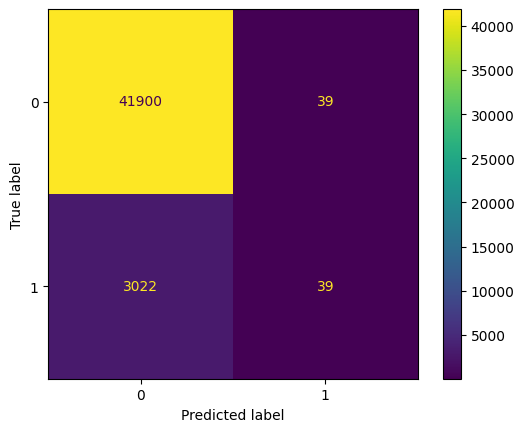

In [35]:
logistic_regression_confusion = confusion_matrix(y_test, logistic_regression_predictions, labels=logistic_regression.classes_)
print(f"Матрица ошибок (confusion_matrix) модели логистической регрессии:")
logistic_regression_confusion_display = ConfusionMatrixDisplay(logistic_regression_confusion, display_labels=logistic_regression.classes_)
logistic_regression_confusion_display.plot()
plt.show()

Из матрицы ошибок можно сделать вывод, что модель логистической регрессии не смогла корректно определить большую часть должников, которые вышли на просрочку.

Далее рассчитаем точность (**precision**) модели логистической регрессии. Precision отражает способность классификатора не принимать за положительное то наблюдение, которое является отрицательным. Точность принимает значения в диапазоне от 0 до 1. Чем больше precision - тем лучше. Точность рассчитывается по следующей формуле:
\begin{align}
  precision = \frac{TP}{TP+NP} ,
\end{align}
где:
- TP - количество истинно положительных
- NP - количество ложно положительных



In [36]:
logistic_regression_confusion_precision = precision_score(y_test, logistic_regression_predictions)
print(f"Точность (precision) модели логистической регрессии: {logistic_regression_confusion_precision}")

Точность (precision) модели логистической регрессии: 0.5


Текущее значение метрики precision означает среднюю адекватность в истинно положительных предсказаниях.

Далее рассчитаем полноту (**recall**) модели логистической регрессии. Recall отражает способность классификатора находить истинно положительные значения. Полнота принимает значения в диапазоне от 0 до 1. Чем больше recall - тем лучше. Полнота рассчитывается по следующей формуле:
\begin{align}
  recall = \frac{TP}{TP+FN} ,
\end{align}
где:
- TP - количество истинно положительных
- FN - количество ложно отрицательных


In [37]:
logistic_regression_confusion_recall = recall_score(y_test, logistic_regression_predictions)
print(f"Recall (полнота обнаружения целевой перменной) модели логистической регрессии: {logistic_regression_confusion_recall}")

Recall (полнота обнаружения целевой перменной) модели логистической регрессии: 0.01274093433518458


Текущее значение recall модели логистической регрессии показывает слабую способность модели в обнаружении истинно положительных значений. С учетом специфики задачи это указывает на то, что модель плохо решает поставленную задачу: нам важно определить как можно больше должников, вышедших на просрочку, чтобы минимизировать потери.

Построим кривую Precision-Recall модели логистической регрессии для того, чтобы определить баланс модели между точностью и полнотой.

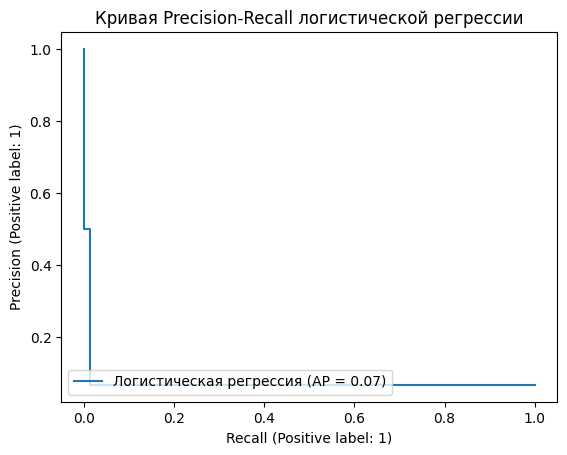

In [38]:
precision_recall_display = PrecisionRecallDisplay.from_predictions(
    y_test, 
    logistic_regression_predictions,
    name="Логистическая регрессия"
)
plt.title("Кривая Precision-Recall логистической регрессии")
plt.show()

Кривая показывает, что модель недостаточно качественная ни по полноте, ни по точности.

Рассчитываем площадь под ROC-кривой. Кривая ошибок ROC (Receiver Operating Characteristic) позволяет оценить качество работы классификатора на различных значниях дискриминационного порога. 

AUC-ROC (площадь под кривой ошибок) модели логистической регрессии: 0.5059055061527851


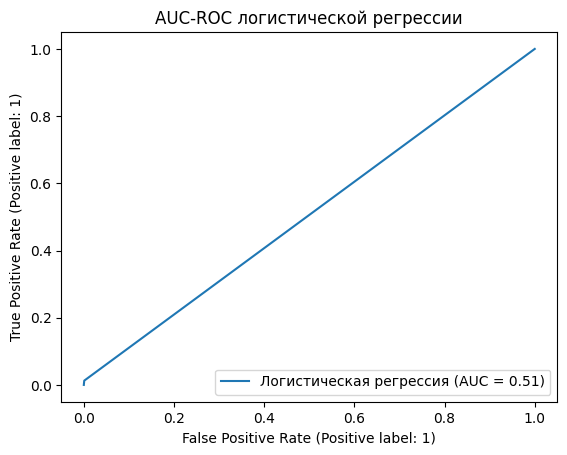

In [39]:
logistic_regression_roc_auc = roc_auc_score(y_test, logistic_regression_predictions)
print(f"AUC-ROC (площадь под кривой ошибок) модели логистической регрессии: {logistic_regression_roc_auc}")
RocCurveDisplay.from_predictions(
    y_test,
    logistic_regression_predictions,
    name="Логистическая регрессия",
)
plt.title("AUC-ROC логистической регрессии")
plt.show()

Данный вид кривой указыает на то, что модель не лучше случайного предсказания.

Посмотрим на вероятности, выдаваемые моделью логистической регрессии.

In [40]:
probabilities = logistic_regression.predict_proba(x_test)
probabilities[:10]

array([[0.97130364, 0.02869636],
       [0.89687275, 0.10312725],
       [0.95836625, 0.04163375],
       [0.91383955, 0.08616045],
       [0.9209411 , 0.0790589 ],
       [0.9658059 , 0.0341941 ],
       [0.98027479, 0.01972521],
       [0.97854212, 0.02145788],
       [0.95575037, 0.04424963],
       [0.93184331, 0.06815669]])

Модель присваивает классу 0 (у клиента не будет просрочки) всегда большие вероятности. Мы можем изменить пороговое значение для перевода вероятности в классы со стандартного значения 0.5.



In [41]:
probabilities_past_due = probabilities[:,1]
adjusted_classes = probabilities_past_due > 0.1

Матрица ошибок (confusion_matrix) модели логистической регрессии после изменения порога вероятности:


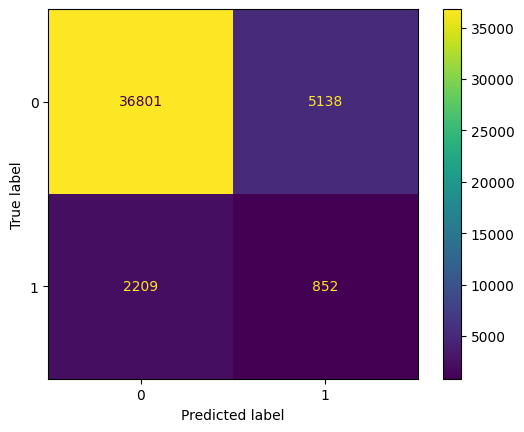

In [42]:
logistic_regression_confusion_adjusted = confusion_matrix(y_test, adjusted_classes, labels=logistic_regression.classes_)
print(f"Матрица ошибок (confusion_matrix) модели логистической регрессии после изменения порога вероятности:")
logistic_regression_adjusted_confusion_display = ConfusionMatrixDisplay(
    logistic_regression_confusion_adjusted, 
    display_labels=logistic_regression.classes_
)
logistic_regression_adjusted_confusion_display.plot()
plt.show()

In [43]:
logistic_regression_adjusted_report = classification_report(y_test, adjusted_classes)
print(f"Основные метрики классификатора (логистической регрессии) после изменения порога:\n{logistic_regression_adjusted_report}")

Основные метрики классификатора (логистической регрессии) после изменения порога:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     41939
           1       0.14      0.28      0.19      3061

    accuracy                           0.84     45000
   macro avg       0.54      0.58      0.55     45000
weighted avg       0.89      0.84      0.86     45000



Снижение порогого значения вероятности класса 1 позволило существенно повысить полноту обнаружения дефолтов, однако снизилась общая меткость модели.

### Дерево решений

Дерево решений - это метод представления правил принятия решений в виде структуры, состоящей из узлов (node) и листьев (leaf). Узлы содержат решающие правила и проверяют данные на выполнение условий этих правил. Листы являются конечными узлами деревьев, для задач классификации листья представляют собой один из классов, ассоциируемых с узлом.

Далее обучим модель дерева решений.

In [44]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier()

Визуализируем первые узлы полученного дерева решений.

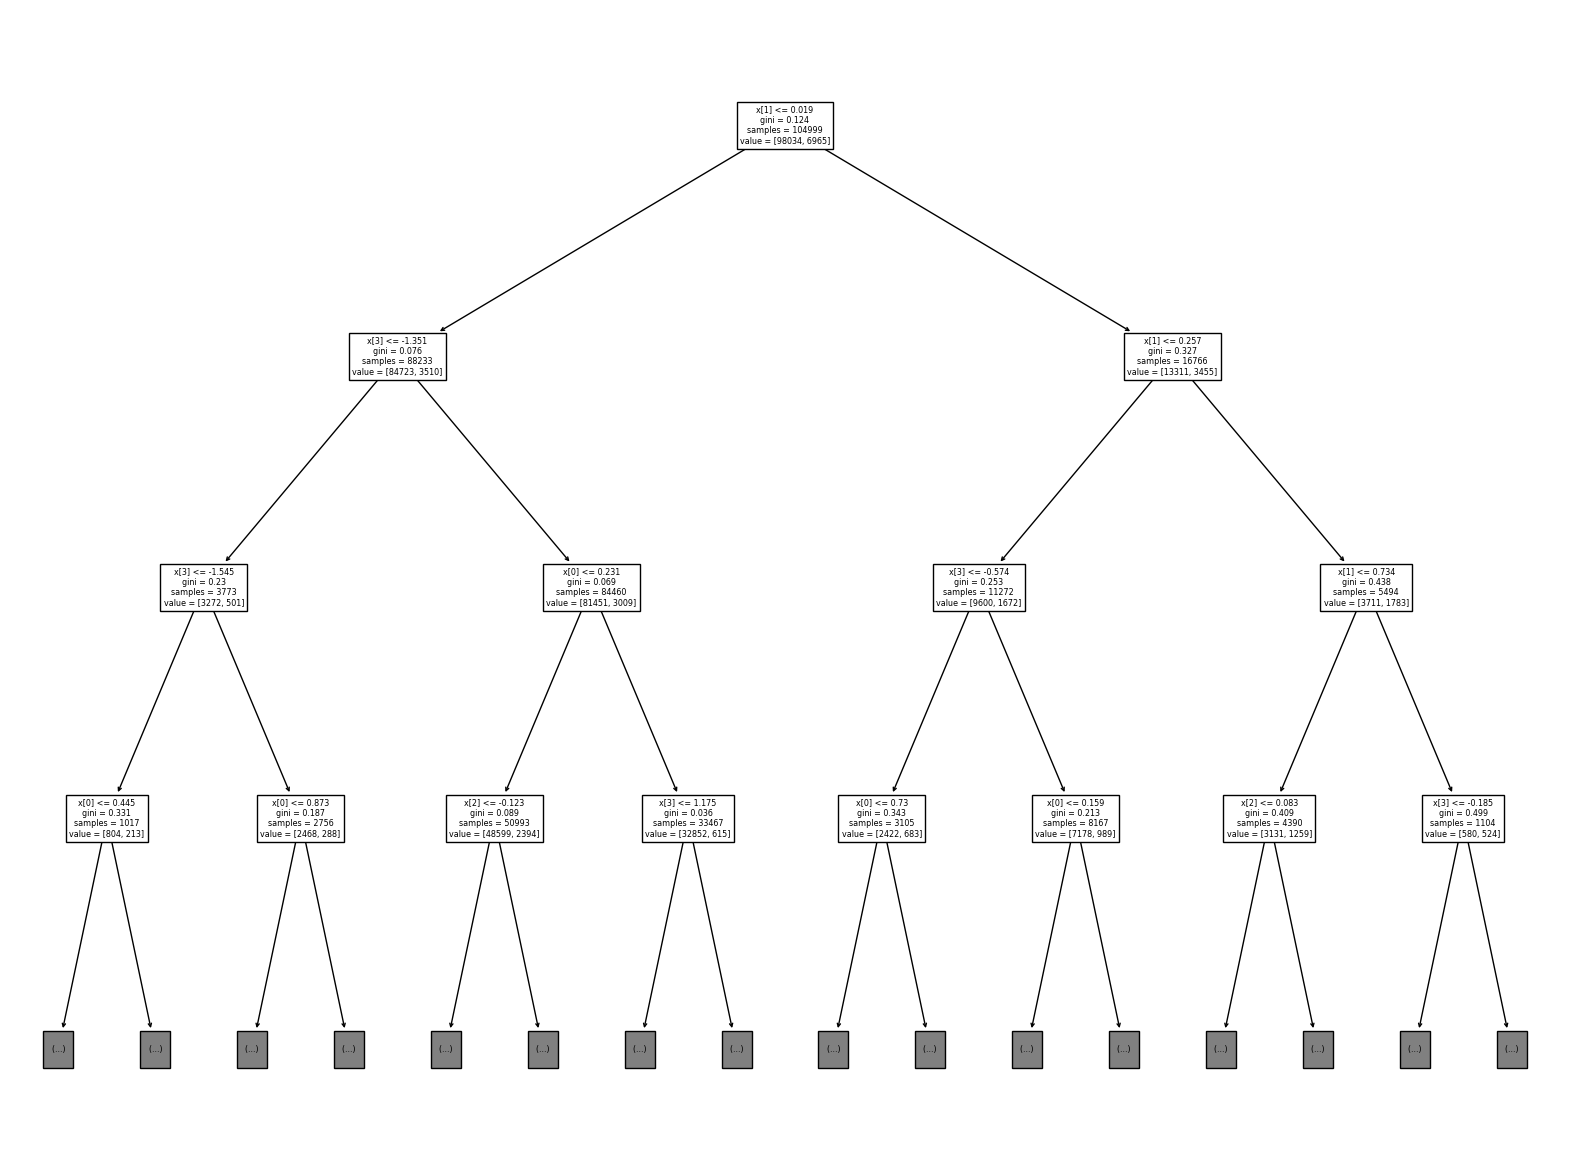

In [45]:
plt.figure(figsize=(20, 15))
plot_tree(decision_tree, max_depth=3)
plt.show()

Получим предсказания на тестовом наборе данных.

In [46]:
decision_tree_predictions = decision_tree.predict(x_test)
decision_tree_probabilities = decision_tree.predict_proba(x_test)

Отобразим основные метрики классификатора.

In [47]:
decision_tree_report = classification_report(y_test, decision_tree_predictions)
print(f"Основные метрики дерева решений:\n{decision_tree_report}")

Основные метрики дерева решений:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     41939
           1       0.17      0.18      0.17      3061

    accuracy                           0.89     45000
   macro avg       0.56      0.56      0.56     45000
weighted avg       0.89      0.89      0.89     45000



In [48]:
decision_tree_accuracy = accuracy_score(y_test, decision_tree_predictions)
print(f"Accuracy (доля правильных предсказаний) модели дерева решений: {decision_tree_accuracy}")

Accuracy (доля правильных предсказаний) модели дерева решений: 0.8867111111111111


In [49]:
decision_tree_balanced_accuracy = balanced_accuracy_score(
    y_test, 
    decision_tree_predictions, 
    adjusted=False
)
print(f"Balanced accuracy модели дерева решений: {decision_tree_balanced_accuracy}")

Balanced accuracy модели дерева решений: 0.5571804287957964


Матрица ошибок (confusion_matrix) модели дерева решений:


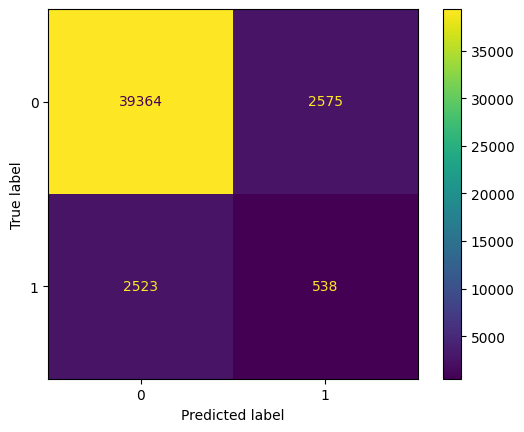

In [50]:
decision_tree_confusion = confusion_matrix(
    y_test, 
    decision_tree_predictions, 
    labels=decision_tree.classes_
)
print(f"Матрица ошибок (confusion_matrix) модели дерева решений:")
decision_tree_confusion_display = ConfusionMatrixDisplay(decision_tree_confusion, display_labels=decision_tree.classes_)
decision_tree_confusion_display.plot()
plt.show()

In [51]:
decision_tree_confusion_precision = precision_score(y_test, decision_tree_predictions)
print(f"Точность (precision) модели дерева решений: {decision_tree_confusion_precision}")

Точность (precision) модели дерева решений: 0.17282364278830709


In [52]:
decision_tree_confusion_recall = recall_score(y_test, decision_tree_predictions)
print(f"Recall (полнота обнаружения целевой перменной) модели дерева решений: {decision_tree_confusion_recall}")

Recall (полнота обнаружения целевой перменной) модели дерева решений: 0.17575955570075139


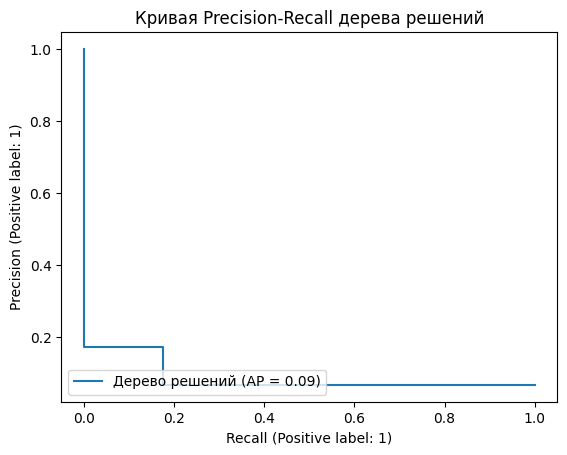

In [53]:
precision_recall_display = PrecisionRecallDisplay.from_predictions(
    y_test, 
    decision_tree_predictions,
    name="Дерево решений"
)
plt.title("Кривая Precision-Recall дерева решений")
plt.show()

AUC-ROC (площадь под кривой ошибок) модели дерева решений: 0.5571804287957964


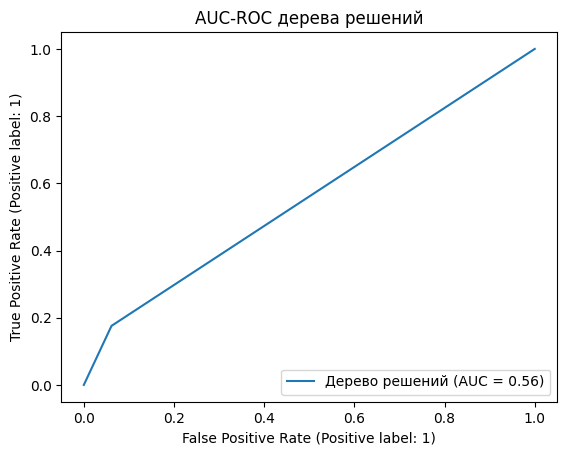

In [54]:
decision_tree_roc_auc = roc_auc_score(y_test, decision_tree_predictions)
print(f"AUC-ROC (площадь под кривой ошибок) модели дерева решений: {decision_tree_roc_auc}")
RocCurveDisplay.from_predictions(
    y_test,
    decision_tree_predictions,
    name="Дерево решений",
)
plt.title("AUC-ROC дерева решений")
plt.show()

Мы видим, что, хотя модель дерева решений демонстрирует более высокую эффективность по сравнению с моделью логистической регрессии, ей присущи те же недостатки: небольшая полнота предсказания истинно положительных наблюдений - то есть, недостаточная адекватность задаче обнаружения должников, выходящих на дефолт по обязательствам.